In [89]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import numpy as np

np.set_printoptions(precision=3, suppress=True)

sin = np.sin
cos = np.cos
tan = np.tan
pi = np.pi



In [57]:
import numpy as np

def interp2(v, xq, yq):
	dim_input = 1
	if len(xq.shape) == 2 or len(yq.shape) == 2:
		dim_input = 2
		q_h = xq.shape[0]
		q_w = xq.shape[1]
		xq = xq.flatten()
		yq = yq.flatten()

	h = v.shape[0]
	w = v.shape[1]
	if xq.shape != yq.shape:
		raise 'query coordinates Xq Yq should have same shape'

	x_floor = np.floor(xq).astype(np.int32)
	y_floor = np.floor(yq).astype(np.int32)
	x_ceil = np.ceil(xq).astype(np.int32)
	y_ceil = np.ceil(yq).astype(np.int32)

	x_floor[x_floor < 0] = 0
	y_floor[y_floor < 0] = 0
	x_ceil[x_ceil < 0] = 0
	y_ceil[y_ceil < 0] = 0

	x_floor[x_floor >= w-1] = w-1
	y_floor[y_floor >= h-1] = h-1
	x_ceil[x_ceil >= w-1] = w-1
	y_ceil[y_ceil >= h-1] = h-1

	v1 = v[y_floor, x_floor]
	v2 = v[y_floor, x_ceil]
	v3 = v[y_ceil, x_floor]
	v4 = v[y_ceil, x_ceil]

	lh = yq - y_floor
	lw = xq - x_floor
	hh = 1 - lh
	hw = 1 - lw

	w1 = hh * hw
	w2 = hh * lw
	w3 = lh * hw
	w4 = lh * lw

	interp_val = v1 * w1 + w2 * v2 + w3 * v3 + w4 * v4

	if dim_input == 2:
		return interp_val.reshape(q_h, q_w)
	return interp_val

# make a rotation matrix given axis x or y or z and angle
def make_rot_mat(axis, angle):
	if axis == 'x':
		return np.array([[1, 0, 0],
						 [0, cos(angle), -sin(angle)],
						 [0, sin(angle), cos(angle)]])
	if axis == 'y':
		return np.array([[cos(angle), 0, sin(angle)],
						 [0, 1, 0],
						 [-sin(angle), 0, cos(angle)]])
	if axis == 'z':
		return np.array([[cos(angle), -sin(angle), 0],
						 [sin(angle), cos(angle), 0],
						 [0, 0, 1]])

q_rx: min: 2.0, max: 30.0
q_ry: min: -15.0, max: 15.0


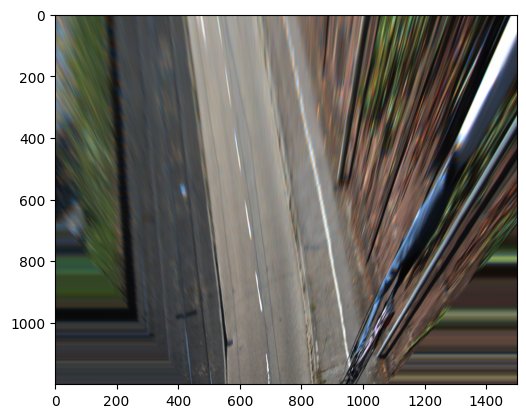

In [138]:
# load image & calibration

image_path = 'imgs/um_000000.png'
image = cv2.imread(image_path)

calib_path = 'imgs/um_000000.txt'

# load calibration
# each line contains <matrix_name>: <data separated by spaces>
# load into a dictionary
f = open(calib_path, 'r')
calib = {}
for line in f:
    line = line.strip()
    if line == '':
        continue
    key, value = line.split(':')
    value = np.array([float(v) for v in value.split()])
    calib[key] = value

P2 = calib['P2'].reshape(3, 4)
K = P2[:, :3]

R_x90 = make_rot_mat('x', pi/2)
R_yn90 = make_rot_mat('y', -pi/2)
R_cw = R_yn90 @ R_x90

t_cw = np.array([0, 1.65, 0])

X_cw = np.hstack((R_cw, t_cw.reshape(3, 1)))
P_cw = K @ X_cw
M = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 0],
              [0, 0, 1]])
PM = P_cw @ M

image_width = image.shape[1]
image_height = image.shape[0]

q_cx, q_cy = np.meshgrid(np.arange(image_width), np.arange(image_height))
q_c = np.stack((q_cx.flatten(), q_cy.flatten(), np.ones_like(q_cx.flatten())), axis=1).T

q_r = np.linalg.inv(PM) @ q_c
q_r = q_r / q_r[2, :]
q_rx = q_r[0, :]
q_ry = q_r[1, :]
# clip values of q_rx
q_rx = np.clip(q_rx, 2, 30)
# clip values of q_ry
q_ry = np.clip(q_ry, -15, 15)
# print max and min values of q_rx and q_ry
print('q_rx: min: {}, max: {}'.format(np.min(q_rx), np.max(q_rx)))
print('q_ry: min: {}, max: {}'.format(np.min(q_ry), np.max(q_ry)))

virtual_image_width = 1500
virtual_image_height = 1500

virtual_image = np.zeros((virtual_image_height, virtual_image_width, 3), dtype=np.uint8)
q_rx, q_ry = np.meshgrid(np.linspace(np.min(q_rx), np.max(q_rx), virtual_image_width),
                         np.linspace(np.min(q_ry), np.max(q_ry), virtual_image_height))
q_r = np.stack((q_rx.flatten(), q_ry.flatten(), np.ones_like(q_rx.flatten())), axis=1).T
q_c = PM @ q_r
q_c = q_c / q_c[2, :]
q_cx = q_c[0, :]
q_cy = q_c[1, :]
q_cx = q_cx.reshape(virtual_image_height, virtual_image_width)
q_cy = q_cy.reshape(virtual_image_height, virtual_image_width)
virtual_image[:,:,0] = interp2(image[:,:,0], q_cx, q_cy).T
virtual_image[:,:,1] = interp2(image[:,:,1], q_cx, q_cy).T
virtual_image[:,:,2] = interp2(image[:,:,2], q_cx, q_cy).T
# flip virtual image upside down
virtual_image = virtual_image[::-1, :, :]
# flip virtual image left to right
virtual_image = virtual_image[:, ::-1, :]
# swap red and blue channels
virtual_image = virtual_image[:, :, [2, 1, 0]]
# crop
virtual_image = virtual_image[:1200, :, :]
plt.imshow(virtual_image)


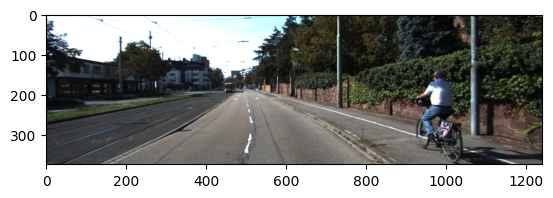

In [137]:
plt.imshow(image[:,:,[2,1,0]])